In [1]:
import urllib2
import numpy as np
from matplotlib import pyplot
from StringIO import StringIO
from caffe2.python import core,workspace,utils
from caffe2.proto import caffe2_pb2

%matplotlib inline

In [2]:
f = urllib2.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
raw_data = f.read()
print("Raw data looks like this:")
print(raw_data[:100] + '...')

Raw data looks like this:
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,...


In [3]:
features = np.loadtxt(StringIO(raw_data), dtype=np.float32, delimiter=',',usecols=(0,1,2,3))
label_converter = lambda s : {'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2}[s]
labels = np.loadtxt(StringIO(raw_data), dtype=np.int, delimiter=',', usecols=(4,), converters={4: label_converter})

In [4]:
random_index = np.random.permutation(150)
features = features[random_index]
labels = labels[random_index]

train_features = features[:100]
train_labels = labels[:100]
test_features = features[100:]
test_labels = labels[100:]

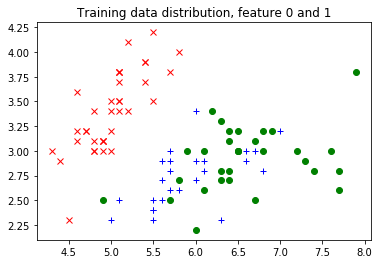

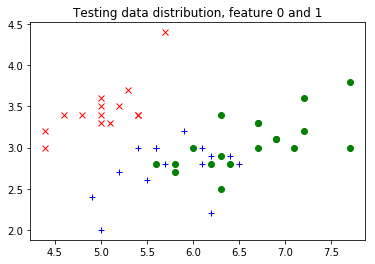

In [7]:
# plot the first two features together with the label
legend = ['rx','b+','go']
pyplot.title('Training data distribution, feature 0 and 1')
for i in range(3):
    pyplot.plot(train_features[train_labels==i,0], train_features[train_labels==i, 1], legend[i])
pyplot.figure()
pyplot.title("Testing data distribution, feature 0 and 1")
for i in range(3):
    pyplot.plot(test_features[test_labels==i, 0], test_features[test_labels==i, 1], legend[i])

In [9]:
feature_and_label = caffe2_pb2.TensorProtos()
feature_and_label.protos.extend([
    utils.NumpyArrayToCaffe2Tensor(features[0]),
    utils.NumpyArrayToCaffe2Tensor(labels[0])
])
print(str(feature_and_label))
print(feature_and_label.SerializeToString())

protos {
  dims: 4
  data_type: FLOAT
  float_data: 5.5
  float_data: 2.40000009537
  float_data: 3.79999995232
  float_data: 1.10000002384
}
protos {
  data_type: INT32
  int32_data: 1
}


  �@��@33s@�̌?
"


In [11]:
# Now, acturally write the db
def write_db(db_type, db_name, features, labels):
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(features.shape[0]):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([
            utils.NumpyArrayToCaffe2Tensor(features[i]),
            utils.NumpyArrayToCaffe2Tensor(labels[i])
        ])
        transaction.put('train_%03d'.format(i),feature_and_label.SerializeToString())
    del transaction
    del db
    
write_db("minidb","iris_train.minidb",train_features, train_labels)
write_db("minidb","iris_test.minidb",test_features, test_labels)

In [12]:
net_proto = core.Net('example_reader')
dbreader = net_proto.CreateDB([], "dbreader", db="iris_train.minidb", db_type="minidb")
net_proto.TensorProtosDBInput([dbreader],["X","Y"], batch_size=16)

print("The net looks like this")
print(str(net_proto.Proto()))

The net looks like this
name: "example_reader"
op {
  output: "dbreader"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "minidb"
  }
  arg {
    name: "db"
    s: "iris_train.minidb"
  }
}
op {
  input: "dbreader"
  output: "X"
  output: "Y"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 16
  }
}



In [13]:
workspace.CreateNet(net_proto)

True

In [14]:
# run batches of features
workspace.RunNet(net_proto.Proto().name)
print(workspace.FetchBlob("X"))
print(workspace.FetchBlob("Y"))

# run batches of features again
workspace.RunNet(net_proto.Proto().name)
print(workspace.FetchBlob("X"))
print(workspace.FetchBlob("Y"))

[[ 5.5         2.4000001   3.79999995  1.10000002]
 [ 6.30000019  2.79999995  5.0999999   1.5       ]
 [ 6.9000001   3.20000005  5.69999981  2.29999995]
 [ 6.          2.20000005  5.          1.5       ]
 [ 6.69999981  2.5         5.80000019  1.79999995]
 [ 5.4000001   3.70000005  1.5         0.2       ]
 [ 5.          3.4000001   1.5         0.2       ]
 [ 4.80000019  3.4000001   1.89999998  0.2       ]
 [ 6.80000019  3.20000005  5.9000001   2.29999995]
 [ 6.69999981  3.0999999   5.5999999   2.4000001 ]
 [ 4.9000001   3.0999999   1.5         0.1       ]
 [ 5.69999981  3.79999995  1.70000005  0.30000001]
 [ 6.80000019  2.79999995  4.80000019  1.39999998]
 [ 4.69999981  3.20000005  1.29999995  0.2       ]
 [ 6.19999981  3.4000001   5.4000001   2.29999995]
 [ 6.80000019  3.          5.5         2.0999999 ]]
[1 2 2 2 2 0 0 0 2 2 0 0 1 0 2 2]
[[ 5.5         2.5         4.          1.29999995]
 [ 6.          2.20000005  4.          1.        ]
 [ 5.80000019  4.          1.20000005  0.2     